In [72]:
import pandas as pd
import numpy as np
import warnings
from plotnine import *
warnings.filterwarnings('ignore')

In [2]:
blog_postings = pd.read_csv('blog_postings.csv')

In [3]:
#일단 포스팅 갯수를 볼거니까 제목과 마지막 행은 날려버리자
blog_postings = blog_postings.drop(blog_postings.columns[5], axis=1)
blog_postings = blog_postings.drop(blog_postings.columns[4], axis=1)

In [4]:
blog_postings.head(3)

,수요미식회,나노하나,20170322,2017. 3. 22. 22:10
0,수요미식회,나노하나,20170322,2017. 3. 22. 12:11\n\t
1,수요미식회,나노하나,20170322,2017. 3. 22. 12:00
2,수요미식회,나노하나,20170322,2017. 3. 22. 19:21\n\t


In [5]:
# 칼럼명 넣기
blog_postings.columns=['프로그램', '식당', '방영일', '포스팅날짜']
blog_postings.head(3)

,프로그램,식당,방영일,포스팅날짜
0,수요미식회,나노하나,20170322,2017. 3. 22. 12:11\n\t
1,수요미식회,나노하나,20170322,2017. 3. 22. 12:00
2,수요미식회,나노하나,20170322,2017. 3. 22. 19:21\n\t


In [6]:
blog_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 4 columns):
프로그램     202 non-null object
식당       202 non-null object
방영일      202 non-null int64
포스팅날짜    202 non-null object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


In [49]:
# 나노하나 식당 테이블 먼저 작업해보기
nanohana = blog_postings[blog_postings['식당'] == '나노하나']
nanohana.head(3)

,프로그램,식당,방영일,포스팅날짜
0,수요미식회,나노하나,20170322,2017. 3. 22. 12:11\n\t
1,수요미식회,나노하나,20170322,2017. 3. 22. 12:00
2,수요미식회,나노하나,20170322,2017. 3. 22. 19:21\n\t


In [50]:
# 포스팅 날짜를 int로 바꾸기 (빼면 간단하니까)
posting_date_split = nanohana['포스팅날짜'].str.split('. ')
dates = pd.Series()
for i, date_list in enumerate(posting_date_split):
    year = date_list[0]
    month = date_list[1]
    month = len(month) > 1 and month or '0'+month
    date = date_list[2]
    date = len(date) > 1 and date or '0'+date
    final_date = int(year+month + date)
    dates.at[i] = final_date


In [51]:
nanohana['포스팅날짜'] = dates

In [52]:
# 방송전후 칼럼만들기
nanohana['방송전후'] = nanohana['방영일'] - nanohana['포스팅날짜']

In [53]:
nanohana.head()

,프로그램,식당,방영일,포스팅날짜,방송전후
0,수요미식회,나노하나,20170322,20170322,0
1,수요미식회,나노하나,20170322,20170322,0
2,수요미식회,나노하나,20170322,20170322,0
3,수요미식회,나노하나,20170322,20170402,-80
4,수요미식회,나노하나,20170322,20170322,0


In [54]:
# 여기 외워서 다시해본다
nanohana.loc[nanohana['방송전후']==0, '방송전후']=0 # 당일
nanohana.loc[nanohana['방송전후']>0, '방송전후']=1 # 방송전 포스팅
nanohana.loc[nanohana['방송전후']<0, '방송전후']=-1 # 방송후 포스팅

In [60]:
nanohana.head()

,프로그램,식당,방영일,포스팅날짜,방송전후
0,수요미식회,나노하나,20170322,20170322,0
1,수요미식회,나노하나,20170322,20170322,0
2,수요미식회,나노하나,20170322,20170322,0
3,수요미식회,나노하나,20170322,20170402,-1
4,수요미식회,나노하나,20170322,20170322,0


In [77]:
nanohana_date_group = pd.DataFrame(nanohana.groupby('포스팅날짜')['프로그램'].count().reset_index())

In [93]:
nanohana_date_group['포스팅날짜'] = nanohana_date_group['포스팅날짜'].astype(str)

In [94]:
nanohana_date_group.head(3)
nanohana_date_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
포스팅날짜    49 non-null object
프로그램     49 non-null int64
dtypes: int64(1), object(1)
memory usage: 864.0+ bytes


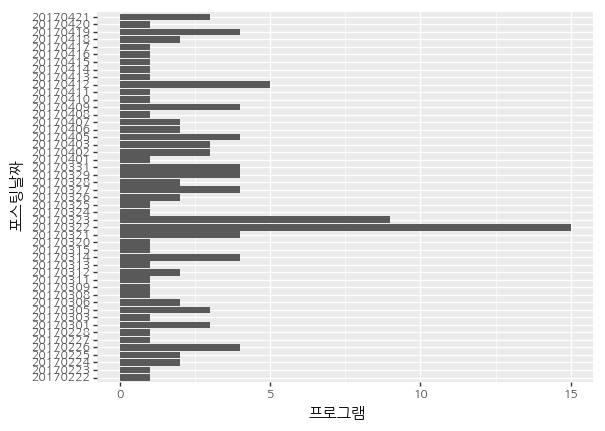

<ggplot: (66877927267)>

In [96]:
(ggplot(nanohana_date_group)
 +aes(x='포스팅날짜', y='프로그램')
 + geom_bar(stat='identity', position='dodge')
  + coord_flip()
 + theme(text=element_text(family='NanumGothic'))
)

# 포스팅이 없어도 날짜는 다 넣어줘야지 비교가 되겠다. 

In [89]:
#방송전후 포스팅 수 비교
nanohana.groupby('방송전후')['프로그램'].count()

방송전후
-1    69
 0    15
 1    37
Name: 프로그램, dtype: int64

In [ ]:
# 여러개 몇일전 칼럼 만들어서 평균값으로 비교해보기
# 포스팅 없는 날짜는 0 넣어서 row 만들기